# Preprocessing des données

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import pandas as pd
import io

#chargement pour google colab
#path = '/content/drive/MyDrive/Colab Notebooks/eco2mix-regional-cons-def.csv'
#df = pd.read_csv(path, sep = ';');

#chargement local
df = pd.read_csv('eco2mix-regional-cons-def.csv', sep=';')

C:\Users\romat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,56,58,60,62,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import preprocessing, model_selection

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm
import scipy.stats

import datetime
%matplotlib inline

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#compte de lignes et compte des NA
print(f'Nombre de lignes total = {len(df)}')
df.isna().sum()

Nombre de lignes total = 1787328


Code INSEE région                                                 0
Région                                                            0
Nature                                                            0
Date                                                              0
Heure                                                             0
Date - Heure                                                      0
Consommation (MW)                                                12
Thermique (MW)                                                   12
Nucléaire (MW)                                               744727
Eolien (MW)                                                     108
Solaire (MW)                                                     12
Hydraulique (MW)                                                 12
Pompage (MW)                                                 779767
Bioénergies (MW)                                                 12
Ech. physiques (MW)                             

### Suppression des colonnes et lignes inutiles et gestion des NA 
Comme vu dans le tableau ci-dessus, certaines colonnes ont un grand nombre de valeurs manquantes (plus de 80% des données). Nous allons supprimer les TCH et les flux car peu significatifs. Pour les TCO, il s'agit des taux de couverture de la consommation seulement calculés après 2020. Nous allons les calculer pour les années précédentes. 

Pour le reste, en ce qui concerne les données en MW, nous allons remplacer les données manquantes par des 0 (car il s'agit de régions sans production nucléaire par exemple) et nous allons supprimer 2 colonnes techniques ainsi que les lignes sans aucune donnée (au nombre de 12).

In [4]:
#drop des colonnes vides ou quasiment vides (les TCO sont les taux de couverture par filière, les flux sont incomplets, le TCH est inconnu)

filter_col2 = [col for col in df if col.startswith('TCH')]
filter_col3 = [col for col in df if col.startswith('Flux')]
filter_col = filter_col2 + filter_col3

df = df.drop(filter_col,axis=1)

#drop des colonnes inutiles (techniques)
df = df.drop(['Nature'],axis=1)

In [5]:
#drop des lignes sans data de consommation ou production
float_list = list(df.select_dtypes('float64').columns)
df = df.dropna(subset=float_list, how='all', axis=0)

#remplissage des NA par des 0 sur les colonnes de consommation et production
for column in float_list:
    df[column].fillna(0, inplace=True)
    
#remplissage des NAN des colonnes de taux de couverture de la consommation par le calcul correspondant
df['TCO Thermique (%)'].fillna((df['Thermique (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Nucléaire (%)'].fillna((df['Nucléaire (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Eolien (%)'].fillna((df['Eolien (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Solaire (%)'].fillna((df['Solaire (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Hydraulique (%)'].fillna((df['Hydraulique (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Bioénergies (%)'].fillna((df['Bioénergies (MW)'] / df['Consommation (MW)']*100), inplace=True)

### Création de nouvelles variables
En premier lieu, des colonnes pour agréger certaines données en MW (renouvelables, un solde brut sans transfert, un solde net avec transfert). Ensuite, nous allons créer des taux de couverture de la consommation. Enfin, nous allons extraire les données liées à la date de chaque ligne.

In [6]:
#feature engineering (création de colonnes agrégées)

df['Renouvelables (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Pompage (MW)']
df['Solde brut (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)'] - df['Consommation (MW)']
df['Solde avec transferts (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)'] + df['Ech. physiques (MW)'] - df['Consommation (MW)']
#remarque sur le pompage: uniquement des valeurs négatives donc représente la consommation d'électricité pour alimenter les pompes des stations de transfert d'énergie (STEP). La production doit alors être classifiée dans l'hydraulique.


#Taux de couvetures de la consommation

df['Taux Couverture (MW)'] = (df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)']) / df['Consommation (MW)']
df['Taux Couverture Renouvelables (MW)'] = df['Renouvelables (MW)'] / df['Consommation (MW)']

In [7]:
#Mise au format date et extraction des éléments de la date en tant que colonnes
df['Date'] = pd.to_datetime(df['Date'])
df['Weekday'] = df['Date'].dt.weekday
df['Jour'] = df['Date'].dt.day
df['Mois'] = df['Date'].dt.month
df['Trimestre'] = pd.PeriodIndex(df['Date'], freq='Q').astype('string') # alternative: ((x.month-1)//3) +1
df['Année'] = df['Date'].dt.year
df['Heure'] = pd.to_datetime(df['Heure'], format='%H:%M').dt.time #alternative: format='%H:%M:%S'
df['Date - Heure'] = pd.to_datetime(df['Date - Heure'], utc=True)

In [8]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe()

,Code INSEE région,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),TCO Thermique (%),TCO Nucléaire (%),TCO Eolien (%),TCO Solaire (%),TCO Hydraulique (%),TCO Bioénergies (%),Renouvelables (MW),Solde brut (MW),Solde avec transferts (MW),Taux Couverture (MW),Taux Couverture Renouvelables (MW),Weekday,Jour,Mois,Année
count,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00
mean,49.92,4499.02,373.95,3678.17,246.14,86.14,608.51,-65.87,81.66,-510.03,1.33,15.09,1.66,0.54,2.12,0.39,956.58,509.67,-0.36,1.22,0.20,3.00,15.72,6.35,2016.76
std,25.64,2173.38,537.57,3876.44,412.40,209.85,1040.19,243.05,44.55,4372.91,4.72,56.66,6.26,3.03,8.60,0.90,1117.32,4372.87,5.63,1.23,0.18,2.00,8.80,3.45,2.46
min,11.00,895.00,-83.00,-144.00,-6.00,-23.00,-14.00,-2570.00,4.00,-12219.00,-2.54,-2.98,-0.10,-0.08,-1.06,0.00,-1280.00,-13960.00,-704.00,-0.18,-0.24,0.00,1.00,1.00,2013.00
25%,27.75,2789.00,24.00,0.00,26.00,0.00,5.00,-1.00,46.00,-4264.00,0.00,0.00,0.00,0.00,0.00,0.00,192.00,-2229.00,-1.00,0.20,0.06,1.00,8.00,3.00,2015.00
50%,48.00,4111.00,153.00,2583.00,101.00,0.00,57.00,0.00,72.00,473.00,0.00,0.00,0.00,0.00,0.00,0.00,471.00,-473.00,0.00,0.90,0.14,3.00,16.00,6.00,2017.00
75%,75.25,5741.00,480.00,6845.00,289.00,63.00,897.00,0.00,114.00,2229.00,0.00,0.00,0.00,0.00,0.00,0.00,1370.00,4264.00,0.00,1.86,0.29,5.00,23.00,9.00,2019.00
max,93.00,15338.00,4293.00,13632.00,4554.00,2392.00,8742.00,0.00,404.00,13959.00,56.89,787.27,100.50,59.47,115.57,7.33,9120.00,12218.00,700.00,8.09,1.31,6.00,31.00,12.00,2021.00


### Import des données météorologiques

Nous allons procéder à l'import du fichier de données météo et à leur intégration. Cependant, le fichier des températures a des intervalles quotidiens, celui du vent et ensoleillement a des intervalles de 3 heures quand nos données électriques ont des intervalles de 30 minutes. Nous allons regrouper nos données électriques par intervalles quotidiens pour ne pas perdre d'information.

In [9]:
meteo_df = pd.read_csv('rayonnement-solaire-vitesse-vent-tri-horaires-regionaux.csv', sep=';')
meteo_df['Date - Heure'] = pd.to_datetime(meteo_df['Date'], utc=True)
meteo_df['Date'] = meteo_df['Date - Heure'].dt.date
meteo_df['Date'] = pd.to_datetime(meteo_df['Date'], utc=True)
meteo_df.sort_values(by=['Date'], inplace=True)
meteo_df = meteo_df.groupby(['Date', 'Code INSEE région', 'Région']).mean().reset_index()

In [10]:
sun_df = pd.read_csv('temperature-quotidienne-regionale.csv', sep=';')
sun_df['Date'] = pd.to_datetime(sun_df['date'], utc=True)
sun_df.drop(['date', 'region'], axis=1, inplace=True)
sun_df.sort_values(by=['Date'], inplace=True)
sun_df.reset_index(drop=True, inplace=True)
sun_df.rename(columns={"code_insee_region": "Code INSEE région"}, inplace=True)

In [11]:
df.reset_index(drop=True, inplace=True)

In [12]:
temp_df = df.groupby(['Date', 'Code INSEE région']).sum().reset_index()
temp_df['Date'] = pd.to_datetime(temp_df['Date'], utc=True)
temp_df.drop(['TCO Thermique (%)', 'TCO Nucléaire (%)', 'TCO Eolien (%)', 'TCO Solaire (%)', 'TCO Hydraulique (%)',
             'TCO Bioénergies (%)','Taux Couverture (MW)', 'Taux Couverture Renouvelables (MW)', 'Weekday', 'Jour', 'Mois', 'Année'], 
             axis=1, inplace=True)

Nous pouvons maintenant fusionner les tableaux et obtenir notre dataset.

In [13]:
temp_df = temp_df.merge(right=meteo_df, on=['Date', 'Code INSEE région'], how='inner')
temp_df = temp_df.merge(right=sun_df, on=['Date', 'Code INSEE région'], how='inner')

In [14]:
'''#v1 par tranche de 3 heures
full_sun_df = sun_df
for i in [3,6,9,12,15,18,21]:
    date = sun_df['Date'] + DateOffset(hours = i)
    new_sun_df = pd.concat([sun_df.drop('Date', axis=1), date], axis=1)
    full_sun_df = pd.concat([full_sun_df, new_sun_df], axis=0)
    
full_sun_df.sort_values(by=['Date'], inplace=True)
full_sun_df.reset_index(drop=True, inplace=True)
full_sun_df['Hour'] = full_sun_df['Date'].dt.hour
full_sun_df.drop('Région', axis=1, inplace=True)
temp_df = temp_df.merge(right=full_sun_df, on=['Date','Hour', 'Code INSEE région'], how='inner')'''

"#v1 par tranche de 3 heures\nfull_sun_df = sun_df\nfor i in [3,6,9,12,15,18,21]:\n    date = sun_df['Date'] + DateOffset(hours = i)\n    new_sun_df = pd.concat([sun_df.drop('Date', axis=1), date], axis=1)\n    full_sun_df = pd.concat([full_sun_df, new_sun_df], axis=0)\n    \nfull_sun_df.sort_values(by=['Date'], inplace=True)\nfull_sun_df.reset_index(drop=True, inplace=True)\nfull_sun_df['Hour'] = full_sun_df['Date'].dt.hour\nfull_sun_df.drop('Région', axis=1, inplace=True)\ntemp_df = temp_df.merge(right=full_sun_df, on=['Date','Hour', 'Code INSEE région'], how='inner')"

Nous allons créer des dummy variables sur la variable catégorielle "Région" et "Mois" et supprimer les colonnes inutiles pour la régression.

In [15]:
temp_df['Mois'] = temp_df['Date'].dt.month

region = pd.get_dummies(temp_df['Région'], prefix='Region').set_index(temp_df['Date'])
mois = pd.get_dummies(temp_df['Mois'], prefix='Mois').set_index(temp_df['Date'])

temp_df.set_index(['Date'], inplace=True)
temp_df.drop(['Mois', 'Région', 'Code INSEE région'], axis=1, inplace=True)

Nous pouvons maintenant fusionner les données quantitatives et les dummies.

In [16]:
temp_df = pd.concat([temp_df, region], axis=1) #, drop_first=True
temp_df = pd.concat([temp_df, mois], axis=1) #, drop_first=True

In [17]:
temp_df.head()

,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),Renouvelables (MW),Solde brut (MW),Solde avec transferts (MW),Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2),tmin,tmax,tmoy,Region_Auvergne-Rhône-Alpes,Region_Bourgogne-Franche-Comté,Region_Bretagne,Region_Centre-Val de Loire,Region_Grand Est,Region_Hauts-de-France,Region_Normandie,Region_Nouvelle-Aquitaine,Region_Occitanie,Region_Pays de la Loire,Region_Provence-Alpes-Côte d'Azur,Region_Île-de-France,Mois_1,Mois_2,Mois_3,Mois_4,Mois_5,Mois_6,Mois_7,Mois_8,Mois_9,Mois_10,Mois_11,Mois_12
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,399184.00,14773.00,0.00,383.00,55.00,471.00,0.00,7091.00,376427.00,8000.00,-376411.00,16.00,8.84,44.57,3.30,8.76,6.03,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-01 00:00:00+00:00,103971.00,3376.00,543053.00,13275.00,391.00,48.00,0.00,2381.00,-458550.00,16095.00,458553.00,3.00,9.20,41.43,1.52,10.73,6.12,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-01 00:00:00+00:00,112383.00,5355.00,0.00,4558.00,489.00,2018.00,0.00,824.00,99160.00,7889.00,-99139.00,21.00,6.18,43.90,2.22,9.52,5.87,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-01 00:00:00+00:00,154861.00,16254.00,304549.00,10537.00,105.00,788.00,0.00,2349.00,-179711.00,13779.00,179721.00,10.00,10.81,23.73,2.78,9.40,6.09,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-01 00:00:00+00:00,263091.00,25772.00,250682.00,34504.00,233.00,105.00,0.00,5930.00,-54148.00,40772.00,54135.00,-13.00,8.91,37.29,1.72,7.72,4.72,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### Analyse des corrélations et discrétisation

Nous allons commencer en regardant les corrélations entre variables.

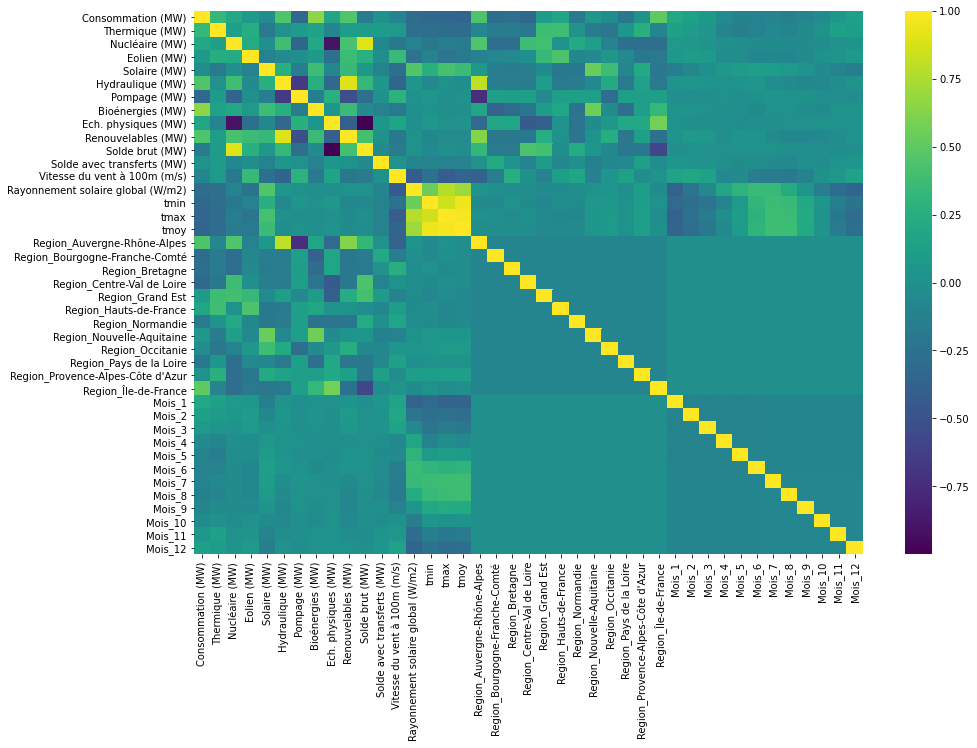

In [18]:
plt.figure(figsize=(15,10))
sns.heatmap(temp_df.corr(), annot=False, center=0, cmap='viridis');

Quelques remarques:
- les températures min, max et moy sont corrélées entre elles. Nous allons en garder qu'une pour notre modèle, la moyenne
- le solde brut, le nucléaire et les échanges physiques sont logiquement mutuellement corrélés (plus de production nucléaire donne un meilleur solde et donc des échanges vers d'autres régions). Nous allons conserver uniquement le solde brut et supprimer les différents types de production et consommation qui ne nous intéressent pas pour cette analyse. De plus, le solde brut qui est la cible capture ces données directement dans son calcul.

**Le but de l'analyse va être de créer un modèle qui en fonction de la région, du mois, des conditions météorologiques et de la consommation évaluera la nature du solde brut de production électrique de la région.**

In [19]:
temp_df.drop(['tmin', 'tmax', 'Consommation (MW)', 'Thermique (MW)', 'Nucléaire (MW)', 'Hydraulique (MW)', 'Eolien (MW)', 'Solaire (MW)', 
              'Pompage (MW)', 'Bioénergies (MW)', 'Ech. physiques (MW)', 'Renouvelables (MW)', 'Solde avec transferts (MW)'], 
             axis=1, inplace=True)

Nous pouvons donc discrétiser la variable cible de notre classification qui sera le Solde brut en fonction des valeurs qu'il prend.

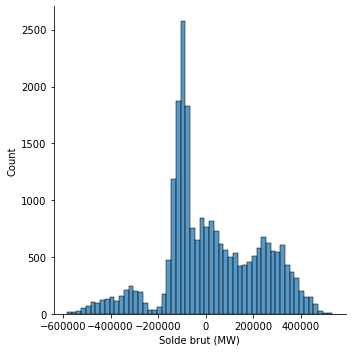

In [20]:
sns.displot(temp_df['Solde brut (MW)']);

Nous allons faire des buckets tous les 200000 MW pour obtenir 6 buckets.

In [21]:
solde_brut = pd.cut(x=temp_df['Solde brut (MW)'], bins=[-600000, -400000, -200000, 0, 200000, 400000, 600000], 
                   labels = ['Déficit3', 'Déficit2', 'Déficit1', 'Excédent1', 'Excédent2', 'Excédent3'])
sb = pd.Series(solde_brut, name='Solde Brut')

temp_df = pd.concat([temp_df, sb], axis=1)
temp_df.drop('Solde brut (MW)', axis=1, inplace=True)

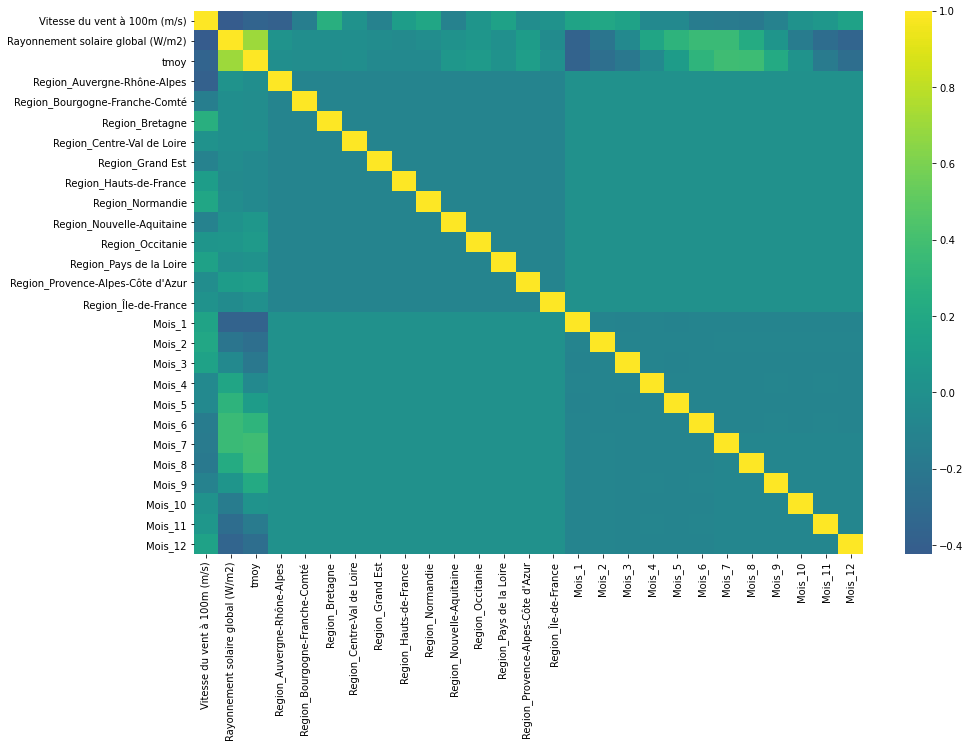

In [22]:
plt.figure(figsize=(15,10))
sns.heatmap(temp_df.corr(), annot=False, center=0, cmap='viridis');

Enfin, nous créons le set de data et de target en supprimant une modalité des dummy variables pour éviter les colinéarités entre variables.

In [23]:
data = temp_df.drop(['Solde Brut', 'Region_Bretagne', 'Mois_3'], axis=1)
target = temp_df['Solde Brut']

Il reste à créer des sets d'entraînement et de test et à les mettre à l'échelle.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

In [25]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Modèle de classification du solde électrique

### Premiers modèles simples

Nous allons procéder à la première analyse de classification avec des classifications de base en utilisant une grille de sélection de modèle.

In [26]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

Nous allons créer une régression et une random forest et effectuer un scoring croisé sur chacun des modèles.
Nous commençons en créant les modèles, leurs paramètres et en créant une liste de ces grilles de sélections.

In [27]:
clf_lr = LogisticRegression()
param_grid_lr = {'solver': ['liblinear', 'lbfgs'],
                   'C': np.linspace(0.1,1,10), 'max_iter' : [1000]}
gcv_lr = GridSearchCV(clf_lr, param_grid_lr, cv=3)

'''clf_svc = SVC()
param_grid_svc = [{'kernel': ['rbf', 'linear'], 'C': [0.1,1,10], 'gamma': np.logspace(0.01,10,5)}]
gcv_svc = GridSearchCV(clf_svc, param_grid_svc, cv=3)'''

clf_rf = RandomForestClassifier()
param_grid_rf  = [{'n_estimators': [10, 50, 100],
                   'min_samples_leaf': [1, 3, 5],
                   'max_features': ['sqrt', 'log2']}]
gcv_rf = GridSearchCV(clf_rf, param_grid_rf, cv=3)

'''gridcvs = {}
for model, params, name in zip((clf_lr, clf_rf, clf_svc), 
                               (param_grid_lr, param_grid_rf, param_grid_svc), 
                               ('Logistic', 'RandomForest', 'SVC')):
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, refit=True)
    gridcvs[name] = grid_cv'''

gridcvs = {}
for model, params, name in zip((clf_lr, clf_rf), 
                               (param_grid_lr, param_grid_rf), 
                               ('Logistic', 'RandomForest')):
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, refit=True)
    gridcvs[name] = grid_cv

In [28]:
folds = StratifiedKFold(n_splits=3, shuffle=True)
outer_scores = {}

for name, model in gridcvs.items():
    score = cross_val_score(model, X_train, y_train, cv=folds)
    outer_scores[name] = score
    print(f'{name}: outer accuracy {100*score.mean():.2f} +/- {100*score.std():.2f}')

Logistic: outer accuracy 82.13 +/- 0.42
RandomForest: outer accuracy 84.66 +/- 0.41


Nous allons prendre le meilleur modèle sur la base de l'accuracy décrite ci-dessus, c'est-à-dire le Random Forest.

In [29]:
from sklearn.metrics import accuracy_score

bestcv = gridcvs['RandomForest']
bestcv.fit(X_train, y_train)
first_clf = bestcv.best_estimator_
print(f'Best params: {bestcv.best_params_}')

train_score = accuracy_score(y_train, y_pred=first_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred=first_clf.predict(X_test))
print(f'Score train: {100*train_score:.2f}')
print(f'Score test: {100*test_score:.2f}')

Best params: {'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 100}
Score train: 90.36
Score test: 85.07


Voici le classification report de ce modèle:

In [30]:
pd.crosstab(y_test, first_clf.predict(X_test), rownames=['Réel'], colnames=['Prédit'])

Prédit,Déficit1,Déficit2,Déficit3,Excédent1,Excédent2,Excédent3
Réel,,,,,,
Déficit3,0,13,118,0,0,0
Déficit2,7,245,18,0,0,0
Déficit1,1949,0,0,135,2,0
Excédent1,149,0,0,852,199,0
Excédent2,0,0,0,104,916,13
Excédent3,0,0,0,0,79,18


In [31]:
from sklearn.metrics import classification_report

scoring = classification_report(y_test, first_clf.predict(X_test))
print(scoring)

              precision    recall  f1-score   support

    Déficit1       0.93      0.93      0.93      2086
    Déficit2       0.95      0.91      0.93       270
    Déficit3       0.87      0.90      0.88       131
   Excédent1       0.78      0.71      0.74      1200
   Excédent2       0.77      0.89      0.82      1033
   Excédent3       0.58      0.19      0.28        97

    accuracy                           0.85      4817
   macro avg       0.81      0.75      0.76      4817
weighted avg       0.85      0.85      0.85      4817



Nous pouvons également identifier les variables les plus importantes de ce modèle:

In [32]:
feats= {}
for feature, importance in zip(data.columns, first_clf.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(10)

,Importance
Region_Île-de-France,0.14
Region_Centre-Val de Loire,0.11
Region_Nouvelle-Aquitaine,0.09
Vitesse du vent à 100m (m/s),0.09
Region_Grand Est,0.09
Region_Normandie,0.08
tmoy,0.07
Region_Auvergne-Rhône-Alpes,0.07
Rayonnement solaire global (W/m2),0.06
Region_Bourgogne-Franche-Comté,0.05


Il apparaît clairement que la région ainsi que les conditions météorologiques sont les facteurs les plus importants dans ce modèle. Le mois de l'année n'est pas dans les 10 facteurs les plus importants.

On peut remarquer que ce modèle est déjà très satisfaisant pour repérer les déficits avec d'excellentes métriques, même sur les déficits les plus graves qui ont pourtant peu d'occurrences. Par contre, cela fonctionne moins bien sur les excédents. 
**Cependant, si nous restons dans une problématique consistant à identifier les risques de déficits électriques, nous pourrions considérer ce modèle comme efficace. Malgré tout, il y a un risque de surapprentissage du modèle comme on peut le constater en comparant les score sur les bases train et test.**

Nous allons donc tester d'autres modèles de manière à voir s'il est possible d'améliorer cela.

### Modèle Bagging avec réduction de dimensions

Nous allons utiliser un modèle de Bagging, qui est censé prévenir l'overfitting tout en améliorant peut-être les performances. Pour accélérer son fonctionnement, nous allons:
- procéder à une réduction de dimensions grâce à l'analyse en composantes principales
- utiliser les bases X qui en découleront pour entraîner un modèle de bagging.

Pour ce qui est de la création des bases avec réduction de dimensions, utilisons la PCA et comparons le nombre de variables:

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [34]:
print(f'Nombre de variables initiales: {X_train.shape[1]}') 
print(f'Nombre de variables après pca: {pca.n_components_}')

Nombre de variables initiales: 25
Nombre de variables après pca: 19


Cela représente une réduction d'un peu plus d'un quart du nombre de variables. Nous allons voir ce qui en résulte dans le modèle BaggingClassifier.

In [35]:
from sklearn.ensemble import BaggingClassifier

clf_bc = BaggingClassifier(n_estimators=50, oob_score=True)

folds = StratifiedKFold(n_splits=3, shuffle=True)
score = cross_val_score(clf_bc, X_train_pca, y_train, cv=folds)
print(f'Bagging: outer accuracy {100*score.mean():.2f} +/- {100*score.std():.2f}')

Bagging: outer accuracy 83.84 +/- 0.28


In [36]:
clf_bc.fit(X_train_pca, y_train)
train_score = accuracy_score(y_train, y_pred=clf_bc.predict(X_train_pca))
test_score = accuracy_score(y_test, y_pred=clf_bc.predict(X_test_pca))
print(f'Score train: {100*train_score:.2f}')
print(f'Score test: {100*test_score:.2f}')

Score train: 99.96
Score test: 84.28


Le score global est assez proche du modèle de RandomForest mais l'overfitting paraît clair avec un 100% de réussite sur la base d'entraînement.
Avec les classification report habituels:

In [37]:
pd.crosstab(y_test, clf_bc.predict(X_test_pca), rownames=['Réel'], colnames=['Prédit'])

Prédit,Déficit1,Déficit2,Déficit3,Excédent1,Excédent2,Excédent3
Réel,,,,,,
Déficit3,0,17,114,0,0,0
Déficit2,5,241,24,0,0,0
Déficit1,1938,1,0,146,1,0
Excédent1,148,0,0,881,170,1
Excédent2,0,0,0,144,853,36
Excédent3,0,0,0,0,64,33


In [38]:
scoring = classification_report(y_test, clf_bc.predict(X_test_pca))
print(scoring)

              precision    recall  f1-score   support

    Déficit1       0.93      0.93      0.93      2086
    Déficit2       0.93      0.89      0.91       270
    Déficit3       0.83      0.87      0.85       131
   Excédent1       0.75      0.73      0.74      1200
   Excédent2       0.78      0.83      0.80      1033
   Excédent3       0.47      0.34      0.40        97

    accuracy                           0.84      4817
   macro avg       0.78      0.77      0.77      4817
weighted avg       0.84      0.84      0.84      4817



Ce modèle a amélioré les performances d'identification des excédents importants au détriment de celle des déficits. Cependant l'overfitting est encore plus présent pour un gain de performance minimal. Ce n'est pas un modèle optimal.

### Modèle XGBoost

Le modèle de classification théoriquement parmi les plus efficaces est le XGBoost. Utilisons-le mais nous allons devoir réencoder les labels des basesy pour que cela soit des entiers.

In [39]:
y_train_xgb = y_train.replace(['Déficit3', 'Déficit2', 'Déficit1', 'Excédent1', 'Excédent2', 'Excédent3'], [0,1,2,3,4,5])
y_test_xgb = y_test.replace(['Déficit3', 'Déficit2', 'Déficit1', 'Excédent1', 'Excédent2', 'Excédent3'], [0,1,2,3,4,5])

In [46]:
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(objective='multi:softprob', num_class=6, use_label_encoder=False, eval_metric='mlogloss')
param_grid_xgb = {'n_estimators': [50], 'max_depth': [3,6,10], 'learning_rate': [0.2], 'gamma': [0,0.1,0.2]}
gcv_xgb = GridSearchCV(clf_xgb, param_grid_xgb, cv=3)

folds = StratifiedKFold(n_splits=3, shuffle=True)
score = cross_val_score(gcv_xgb, X_train_pca, y_train_xgb, cv=folds)

print(f'XGB: outer accuracy {100*score.mean():.2f} +/- {100*score.std():.2f}')

XGB: outer accuracy 84.01 +/- 0.42


In [47]:
gcv_xgb.fit(X_train_pca, y_train_xgb)
best_clf_xgb = gcv_xgb.best_estimator_
print(f'Best params: {gcv_xgb.best_params_}')

Best params: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50}


In [49]:
train_score = accuracy_score(y_train_xgb, y_pred=best_clf_xgb.predict(X_train_pca))
test_score = accuracy_score(y_test_xgb, y_pred=best_clf_xgb.predict(X_test_pca))
print(f'Score train: {100*train_score:.2f}')
print(f'Score test: {100*test_score:.2f}')

Score train: 89.47
Score test: 84.47


Les résultats de ce modèle sont semblables à ceux de la Random Forest: même écart entre test et train, même niveau d'accuracy.

Voici les classification report:

In [50]:
y_pred = best_clf_xgb.predict(X_test_pca)
y_pred = np.where(y_pred == 0, 'Déficit3', y_pred)
y_pred = np.where(y_pred == '1', 'Déficit2', y_pred)
y_pred = np.where(y_pred == '2', 'Déficit1', y_pred)
y_pred = np.where(y_pred == '3', 'Excédent1', y_pred)
y_pred = np.where(y_pred == '4', 'Excédent2', y_pred)
y_pred = np.where(y_pred == '5', 'Excédent3', y_pred)
#y_pred = pd.Series(y_pred).replace([0,1,2,3,4,5], ['Déficit3', 'Déficit2', 'Déficit1', 'Excédent1', 'Excédent2', 'Excédent3'])

pd.crosstab(y_test, y_pred, rownames=['Réel'], colnames=['Prédit'])

Prédit,Déficit1,Déficit2,Déficit3,Excédent1,Excédent2,Excédent3
Réel,,,,,,
Déficit3,0,16,115,0,0,0
Déficit2,5,242,23,0,0,0
Déficit1,1940,3,0,142,1,0
Excédent1,147,0,0,869,183,1
Excédent2,0,0,0,129,877,27
Excédent3,0,0,0,0,71,26


In [51]:
scoring = classification_report(y_test, y_pred)
print(scoring)

              precision    recall  f1-score   support

    Déficit1       0.93      0.93      0.93      2086
    Déficit2       0.93      0.90      0.91       270
    Déficit3       0.83      0.88      0.86       131
   Excédent1       0.76      0.72      0.74      1200
   Excédent2       0.77      0.85      0.81      1033
   Excédent3       0.48      0.27      0.34        97

    accuracy                           0.84      4817
   macro avg       0.78      0.76      0.77      4817
weighted avg       0.84      0.84      0.84      4817



Nous pouvons faire toujours le même constat: les cas extrêmes d'excédent sont difficilement identifiés dans tous nos modèles. Cependant, il y a toujours une bonne qualité de prédiction sur les déficits.

### Modèles avec rééquilibrage des données

Nous allons procéder maintenant à de l'oversampling pour rééqulibrer notre set de données et y entraîner une RandomForest et un XGBoost. Le but est de voir si cela corrige nos modèles de leur surapprentissage, tout en permettant d'identifier le meilleur modèle.

In [57]:
from imblearn.over_sampling import RandomOverSampler

rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
print(f'Classes Oversamplées: {dict(pd.Series(y_ro).value_counts())}')

Classes Oversamplées: {'Déficit3': 8499, 'Déficit2': 8499, 'Déficit1': 8499, 'Excédent1': 8499, 'Excédent2': 8499, 'Excédent3': 8499}


Maintenant que nous avons notre base oversamplée, entraînons nos modèles grâce à une cross-validation.

In [58]:
clf_ros_rf = RandomForestClassifier()
param_grid_ros_rf  = [{'n_estimators': [10, 50, 100],
                   'min_samples_leaf': [1, 3, 5],
                   'max_features': ['sqrt', 'log2']}]
gcv_ros_rf = GridSearchCV(clf_ros_rf, param_grid_ros_rf, cv=3)

clf_ros_xgb = xgb.XGBClassifier(objective='multi:softprob', num_class=6, use_label_encoder=False, eval_metric='mlogloss')
param_grid_ros_xgb = {'n_estimators': [50], 'max_depth': [3,6,10], 'learning_rate': [0.2], 'gamma': [0,0.1,0.2]}
gcv_ros_xgb = GridSearchCV(clf_ros_xgb, param_grid_ros_xgb, cv=3)

In [59]:
#Entraînement de la Random Forest sur la base ROS
folds = StratifiedKFold(n_splits=3, shuffle=True)
score = cross_val_score(gcv_ros_rf, X_ro, y_ro, cv=folds)

print(f'Random Forest: outer accuracy {100*score.mean():.2f} +/- {100*score.std():.2f}')

Random Forest: outer accuracy 96.01 +/- 0.07


In [61]:
#Entraînement du XGB sur la base ROS
y_ro_xgb = y_ro.replace(['Déficit3', 'Déficit2', 'Déficit1', 'Excédent1', 'Excédent2', 'Excédent3'], [0,1,2,3,4,5])
folds = StratifiedKFold(n_splits=3, shuffle=True)
score = cross_val_score(gcv_ros_xgb, X_ro, y_ro_xgb, cv=folds)

print(f'XGB: outer accuracy {100*score.mean():.2f} +/- {100*score.std():.2f}')

XGB: outer accuracy 92.81 +/- 0.19


Le modèle donnant le meilleur résultat pour l'instant est la Random Forest. Faisons travailler les deux modèles sur la base de test.

In [64]:
gcv_ros_rf.fit(X_ro, y_ro)
best_ros_rf = gcv_ros_rf.best_estimator_
print(f'Best params: {gcv_ros_rf.best_params_}')

train_score = accuracy_score(y_ro, y_pred=best_ros_rf.predict(X_ro))
test_score = accuracy_score(y_test, y_pred=best_ros_rf.predict(X_test))
print(f'Score train: {100*train_score:.2f}')
print(f'Score test: {100*test_score:.2f}')

Best params: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}
Score train: 99.99
Score test: 84.58


In [65]:
gcv_ros_xgb.fit(X_ro, y_ro_xgb)
best_ros_xgb = gcv_ros_xgb.best_estimator_
print(f'Best params: {gcv_ros_xgb.best_params_}')

train_score = accuracy_score(y_ro_xgb, y_pred=best_ros_xgb.predict(X_ro))
test_score = accuracy_score(y_test_xgb, y_pred=best_ros_xgb.predict(X_test))
print(f'Score train: {100*train_score:.2f}')
print(f'Score test: {100*test_score:.2f}')

Best params: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 50}
Score train: 95.32
Score test: 83.39


Ces modèles ne sont pas pour l'instant convaincants car n'améliorant pas les résultats sur la base de test tout en accroissant le surapprentissage. Regardons les classification report du modèle XGB qui a le surapprentissage le plus faible.

In [66]:
y_pred = best_ros_xgb.predict(X_test)
y_pred = np.where(y_pred == 0, 'Déficit3', y_pred)
y_pred = np.where(y_pred == '1', 'Déficit2', y_pred)
y_pred = np.where(y_pred == '2', 'Déficit1', y_pred)
y_pred = np.where(y_pred == '3', 'Excédent1', y_pred)
y_pred = np.where(y_pred == '4', 'Excédent2', y_pred)
y_pred = np.where(y_pred == '5', 'Excédent3', y_pred)

pd.crosstab(y_test, y_pred, rownames=['Réel'], colnames=['Prédit'])

Prédit,Déficit1,Déficit2,Déficit3,Excédent1,Excédent2,Excédent3
Réel,,,,,,
Déficit3,0,15,116,0,0,0
Déficit2,6,246,18,0,0,0
Déficit1,1871,8,0,206,1,0
Excédent1,97,0,0,913,189,1
Excédent2,0,0,0,114,795,124
Excédent3,0,0,0,0,21,76


In [67]:
scoring = classification_report(y_test, y_pred)
print(scoring)

              precision    recall  f1-score   support

    Déficit1       0.95      0.90      0.92      2086
    Déficit2       0.91      0.91      0.91       270
    Déficit3       0.87      0.89      0.88       131
   Excédent1       0.74      0.76      0.75      1200
   Excédent2       0.79      0.77      0.78      1033
   Excédent3       0.38      0.78      0.51        97

    accuracy                           0.83      4817
   macro avg       0.77      0.83      0.79      4817
weighted avg       0.85      0.83      0.84      4817



Ce dernier tableau nous fait apparaître un gain réel de ce dernier modèle: les recall sont tous supérieurs à 75%, la classification de la catégorie Excédent 3 s'est améliorée considérablement par rapport aux autres modèles, la contrepartie étant de perdre un peu de qualité dans la classification de la catégorie Excédent2.

**Nous pouvons conserver ce modèle en tant que meilleur modèle car fonctionnant le mieux sur toutes les sous-catégories et notamment les plus extrêmes, qui sont la cible de notre analyse.**

### Interprétation

Nous allons utiliser SHAP pour analyser le fonctionnement du modèle de classification.

In [69]:
import shap

explainer = shap.TreeExplainer(best_ros_xgb, output_margin=True)
shap_values = explainer.shap_values(X_test)

In [89]:
feat_ids = pd.DataFrame(data.columns, columns=['Name'])
feat_ids

,Name
0,Vitesse du vent à 100m (m/s)
1,Rayonnement solaire global (W/m2)
2,tmoy
3,Region_Auvergne-Rhône-Alpes
4,Region_Bourgogne-Franche-Comté
5,Region_Centre-Val de Loire
6,Region_Grand Est
7,Region_Hauts-de-France
8,Region_Normandie
9,Region_Nouvelle-Aquitaine


Voici la liste des variables importantes dans le modèle.

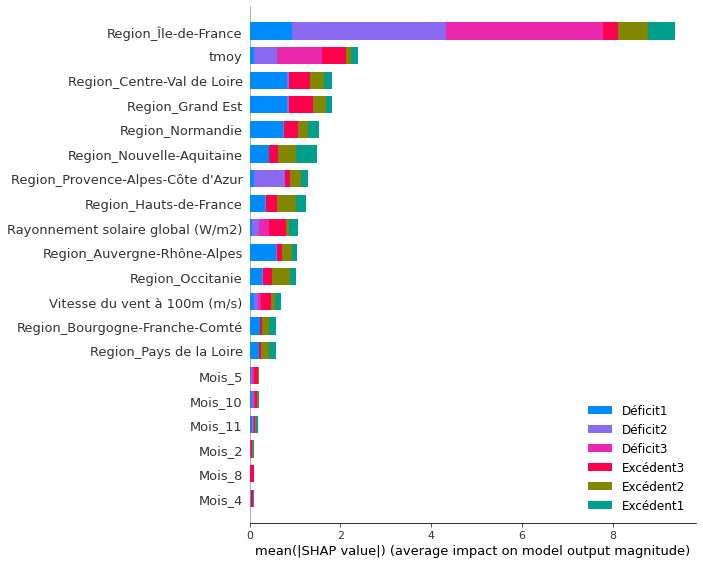

In [81]:
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names = data.columns, 
                  class_names=['Déficit3', 'Déficit2', 'Déficit1', 'Excédent1', 'Excédent2', 'Excédent3'])

Quelques conclusions:
-  Il apparaît clairement que la région Ile-de-France est déterminante dans le classement. En effet, étant en déficit permanent, elle effectue un premier tri essentiel parmi les données.
- Les régions dans leur ensemble sont les principaux facteurs de classification.
- Les variables météorologiques ont un impact, et plus spécifiquement la température moyenne qui est le second facteur de classification.
- Les mois ne sont quasiment pas utilisés par le modèle.

Si nous nous concentrons sur les classifications des classes extrêmes:

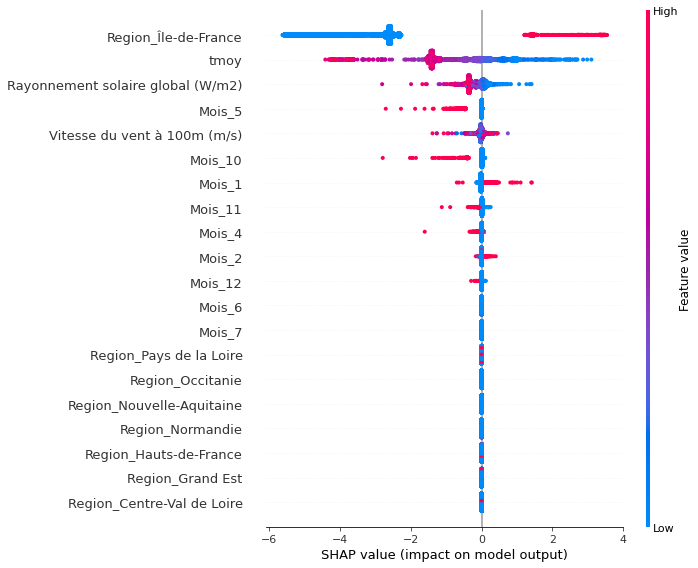

In [97]:
shap.summary_plot(shap_values[0], X_test, feature_names = data.columns)

Les déficits extrêmes sont déterminés principalement par la région Ile-de-France qui concentre ce type de situations. La température quant à elle va avoir une relation importante et inverse: plus il fait chaud, moins on aura de chances d'être en déficit électrique. Les autres variabels sont quasi négligeables (y compris les autres régions).

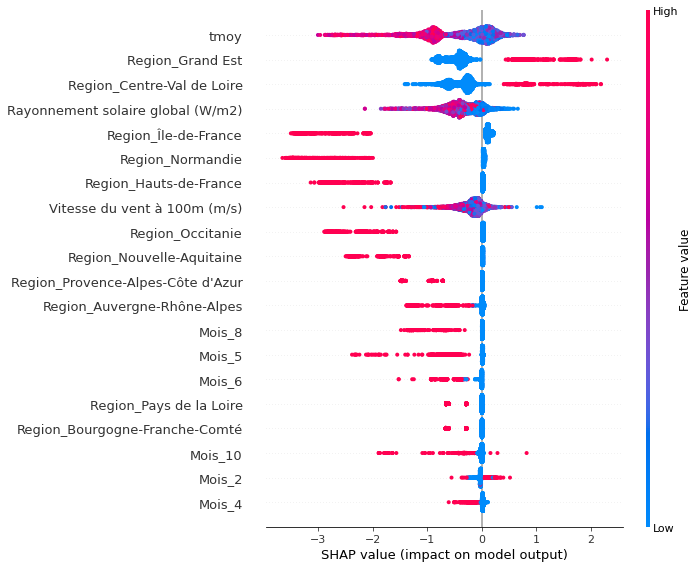

In [98]:
shap.summary_plot(shap_values[5], X_test, feature_names = data.columns)

Dans le cas de l'excédent extrême, il est déterminé par les régions Grand-Est et Centre-Val de Loire mais la température est le facteur principal en jeu. PLus il fait chaud, moins il y aura d'excédent extrême.

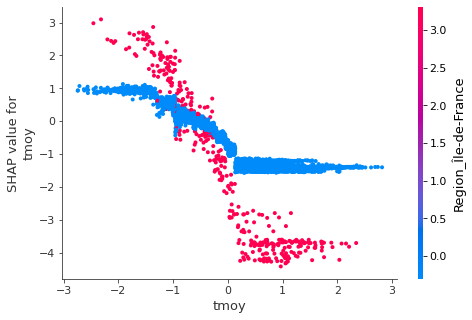

In [95]:
shap.dependence_plot(2, shap_values[0], X_test, feature_names=data.columns) #interaction_index= "capital-gain"

Ici nous pouvons vois la différence de profil de l'Ile-de-France par rapport aux autres régions. En bleu, nous avons le reste de la France, chaque point représentant la contribution au classement en déficit extrême suivant la température. La température joue clairement un rôle: plus elle est basse, plus on pourra être en déficit extrême. Cependant, l'effet est amplifié pour l'Ile-de-France: cela signifie que la combinaison froid + Ile-de-France est déterminante pour une prévision de déficit extrême.

Ci-dessous, voici un exemple de classification en déficit extrême en utilisant Javascript. Cela reste commenté car ne fonctionne pas de manière native avec la visualisation Git mais le code est utilisable.

In [126]:
'''shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][101,:], X_test[101,:], feature_names=data.columns)'''

Voici les lignes de la base de test classifiées en déficit extrême:

In [121]:
id = pd.DataFrame(shap_values[0]).sum(axis=1)
id[id >0]

20     2.68
48     2.66
71     0.00
91     0.88
101    1.29
167    6.15
185    1.50
201    3.05
221    5.57
230    0.67
260    2.53
321    6.39
327    6.00
349    6.16
356    5.30
385    6.05
412    3.71
415    5.76
448    0.49
521    5.89
538    2.53
598    0.01
612    5.10
680    3.38
718    5.56
763    4.99
769    6.09
770    5.42
771    1.08
784    4.71
826    4.76
829    6.15
877    6.39
919    4.53
944    5.72
945    1.84
1051   6.06
1072   2.42
1073   6.15
1107   2.65
1127   6.47
1129   2.91
1151   3.42
1158   2.47
1233   4.21
1234   2.59
1275   4.90
1295   6.18
1308   5.69
1326   6.30
1402   4.06
1431   1.02
1453   4.77
1477   2.17
1481   4.90
1484   1.33
1487   5.67
1498   6.11
1545   1.61
1584   3.82
1613   0.03
1628   6.39
1638   6.15
1639   2.38
1734   4.30
1777   3.99
1842   1.99
1856   5.93
1902   1.01
1990   1.61
2001   2.11
2040   6.39
2070   5.10
2137   0.53
2165   3.29
2229   5.57
2230   6.47
2242   6.05
2265   4.98
2270   2.27
2280   5.12
2304   1.50
2321   3.42
2333

**Au final, ce modèle fonctionne relativement efficacement pour déterminer les occurrences de cas extrêmes dans les soldes électriques. Il pourrait être amélioré en trouvant d'autres sources de données explicatives mais en l'état, il constitue une base de travail raisonnablement fiable.**